In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Question 13
The following questions should be answered using the **Weekly** data set.

Importing Weekly data and checking for any basic cleanup.

In [3]:
weekly = pd.read_csv("Weekly.csv")
weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [4]:
weekly.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [5]:
np.unique(weekly['Direction'])

array(['Down', 'Up'], dtype=object)

In [6]:
np.unique(np.isnan(weekly[['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today']]))

array([False])

There's no missing values that I need to deal with, which is to be expected from a textbook exercise.

#### a)
Produce some numerical and graphical summaries of the Weekly 
data  Do there appear to be any patterns?

In [8]:
weekly[['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today']].describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [9]:
weekly.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


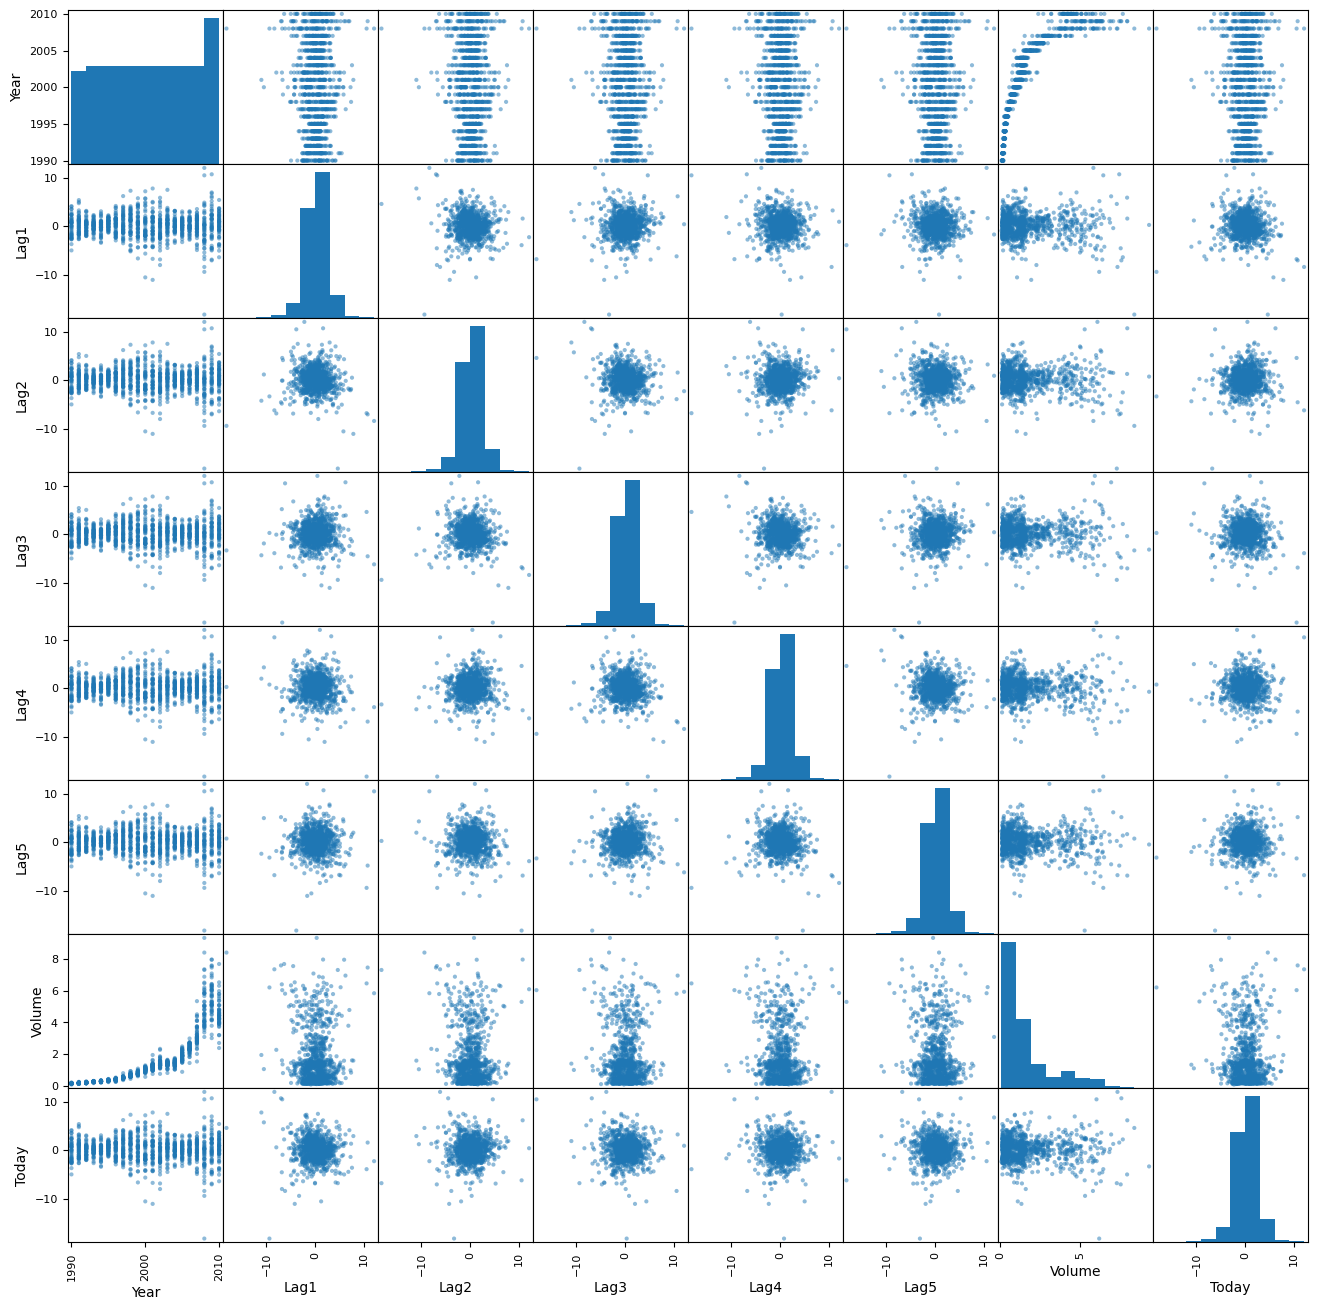

In [10]:
pd.plotting.scatter_matrix(weekly,figsize=(16,16));

Most data is centralized, with Volume having a left skew. I'll probably want to scale the data if I use KNN on it. Volume and Year are *very* correlated, otherwise there's no obvious patterns I'm noticing from a visual check.

#### b)

Use the full data set to perform a logistic regression with 
Direction as the response and the ifve lag variables plus Volum 
as predictors. Use the summary function to print the results.  o
any of the predictors appear to be statistically signifcant? If  o,
which ones?

In [12]:
allvars = weekly.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X1 = design.fit_transform(weekly)
y = weekly.Direction == 'Up'
glm = sm.GLM(y,
             X1,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


Looking at p-values, Lag2 appears to be the only value doing much of anything (and even then, 0.03 isn't a particularly impressive p-value for a predictor).

#### c)

Compute the confusion matrix and overall fraction of correct 
predictions. Explain what the confusion matrix is telling yo 
about the types of mistakes made by logistic regression.

In [14]:
labels = np.array(['Down']*1089)
probs = results.predict()
labels[probs>0.5] = "Up"
confusion_table(labels, weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [15]:
np.mean(labels == weekly.Direction), np.mean(labels != weekly.Direction)

(0.5610651974288338, 0.4389348025711662)

In [16]:
430/(430+54), 48/(557+48)

(0.8884297520661157, 0.07933884297520662)

Logistic regression has an accuracy of 56.1% of the time and an error rate of 43.9% - a little better than flipping a coin.

Type 1 Error Rate: 88.8%

Type 2 Error Rate: 7.9%

The logistic model will return a very high number of incorrect "Up"s compared to incorrectly assigning "Down"s. Which type of error an individual wants to reduce depends on their willingness to assume stock risk in this case.

#### d)

Now fit the logistic regression model using a training data period 
from 1990 to 2008, with Lag2 as the only predictor. Compute th 
confusion matrix and the overall fraction of correct predictno s
for the held out data (that is, the data from 2009 and 2010).

In [18]:
#separating training and testing data by year
train = (weekly.Year <= 2008)

#refitting to just Lag2 predictor
model = MS(['Lag2']).fit(weekly)
X = model.fit_transform(weekly)

X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

#training the logistic regression model on the training data
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

#assigning the correct labels to the rows for confusion matric readability
D = weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]

#assigning labels to predicted observations
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [19]:
np.mean(labels == L_test), np.mean(labels != L_test)

(0.625, 0.375)

In [42]:
34/43, 5/61

(0.7906976744186046, 0.08196721311475409)

The logistic regression on test data has an overall accuracy of 62.5% and an error rate of 37.5%

Type 1 Error Rate: 79.1%

Type 2 Error Rate: 8.2%

Going down to a statistically significant predictor made a huge difference! Overall accuracy and error rate are much improved, though both types of errors also increased. This model incorrectly assigns "Up"s ~80% of the time and incorrectly assigns "Down"s ~8% of the time. This isn't a good choice of a model if you're looking to find "Up"s - you could change the decision threshold to something other than 50%. This would only change the Type 1/2 Error rates, not the overall accurracy or error rates.

#### e)

Repeat (d) using LDA.

In [22]:
lda = LDA(store_covariance=True)

#need to drop the intercept since lda adds its own
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]

#fitting lda
lda.fit(X_train, L_train)

#generating predicted observations
lda_pred = lda.predict(X_test)

#confution matrix
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [40]:
np.mean(lda_pred == L_test), np.mean(lda_pred != L_test)

(0.625, 0.375)

In [44]:
34/43, 5/61

(0.7906976744186046, 0.08196721311475409)

LDA performs the same as logistic regression. Nothing new to add.

#### f)

Repeat (d) using QDA.

In [47]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [49]:
np.mean(qda_pred == L_test), np.mean(qda_pred != L_test)

(0.5865384615384616, 0.41346153846153844)

In [51]:
43/43, 0/61

(1.0, 0.0)

Well I thought I did something wrong! Because this confusion matrix for QDA is wild!

The QDA on test data has an overall accuracy of 58.6% and an error rate of 41.3%

Type 1 Error Rate: 100%

Type 2 Error Rate: 0%

QDA assigned everything as an "Up". I *definitely* wouldn't trust this model from the looks of it, but the overall accurracy is still better than flipping a coin somehow.

#### g)

Repeat (d) using KNN with K = 1.

In [55]:
knn1 = KNeighborsClassifier(n_neighbors=1)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,22,30
Up,21,31


In [57]:
np.mean(knn1_pred == L_test), np.mean(knn1_pred != L_test)

(0.5096153846153846, 0.49038461538461536)

In [59]:
21/43, 30/61

(0.4883720930232558, 0.4918032786885246)

The KNN with K=1 on test data has an overall accuracy of 51.0% and an error rate of 49.0%

Type 1 Error Rate: 48.8%

Type 2 Error Rate: 49.2%

If you use this model, a coin flip might be more accurrate and less time consuming in the long run.

#### h)

Repeat (d) using naive Bayes.

In [62]:
NB = GaussianNB()
NB.fit(X_train, L_train)
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [64]:
np.mean(nb_labels == L_test), np.mean(nb_labels != L_test)

(0.5865384615384616, 0.41346153846153844)

In [67]:
43/43, 0/61

(1.0, 0.0)

Naive Bayes did the same thing as QDA. No new comments.

#### i)

Which of these methods appears to provide the best results on 
this data

Logistic regression and LDA porformed the best on the data with an overall accuracy of 62.5% and an error rate of 37.5%. I wouldn't use either model to make decisions on the stock market, sinced they're not *that* accurate in the grand scheme of things.?

### Question 14
In this problem, you will develop a model to predict whether a given 
car gets high or low gas mileage based on the Auto data set
#### a)
Create a binary variable, mpg01, that contains a 1 if mpg contains 
a value above its median, and a 0 if mpg contains a value belo 
its median..